# Statistics on sub-grid topography
This notebook is aiming to explore what kind of information about GCM sub-grid topography is important for convection parameterization in mountainous regions.
We are using the ~1km resolution dataset found on that website :
https://visibleearth.nasa.gov/images/73934/topography/84331l

In [1]:
"""
Created on Mon Sep 11 08:19:26 2023

@author: Nathan Philippot
"""

from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
from numba import njit,prange
import xarray as xr
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import LightSource
import matplotlib
import warnings
warnings.filterwarnings('ignore')
hcm = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","saddlebrown","grey","w"])
path = "C:/Users/Nathan/Documents/Thèse/Topography statistics/"

In [2]:
Hmax = 6400
H = np.flipud(np.asarray(Image.open(path+"World_topo_1km.png")))
# H = np.asarray(xr.open_dataset('C:/Users/Nathan/Documents/Thèse/Topography statistics/World_topo_1km.nc').Band1) #* Hmax/255

ny,nx = np.shape(H)
dx = 40_000_000 / nx #meters
res = 360/nx
c = 100 # number of pixel per grid cell

## World map statistics relative to mean altitude
We divide the world in 100x100km cells equivalent to a normal GCM grid.

In [3]:
@njit(parallel=True)
def subgrid_statistics(H,c):
    ny,nx = np.shape(H)
    ny_,nx_ = ny//c , nx//c
    stats = np.zeros((ny_,nx_,5))
    for i in prange(nx_):
        for j in range(ny_):
            Hc = H[j*c:(j+1)*c,i*c:(i+1)*c] /255 * Hmax
            Hc_mean = np.mean(Hc)
            Hc_max = np.max(Hc)
            Hc_min = np.min(Hc)
            Hc_below_mean_fraction = np.mean(Hc<Hc_mean)
            Hc_mean_slope = np.mean(np.sqrt( ((Hc[:-1,:-1]+Hc[1:,:-1]-Hc[:-1,1:]-Hc[1:,1:])/2/dx/np.cos(np.pi*(-90+j*c*res)/180))**2 + ((Hc[:-1,:-1]+Hc[:-1,1:]-Hc[1:,:-1]-Hc[1:,1:])/2/dx)**2 ))
            stats[j,i,:] = np.array([Hc_mean , Hc_max , Hc_min , Hc_below_mean_fraction,Hc_mean_slope])
            
    return stats

def show_map(data,cmap,vmin,vmax,name):
    fig = plt.figure(figsize=(10, 8/nx*ny  ) )
    ax_image = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax_image.set_xlim(-180,180)
    ax_image.set_ylim(-90,90)
    ax_image.set_xticks([])
    ax_image.set_yticks([])
    image = ax_image.imshow(data, cmap=cmap,vmin=vmin,vmax =vmax, extent=(-180,180,-90,90), origin= 'lower')
    extend = 'max' if vmin==0 else 'min' if vmax==0 else 'both'
    fig.colorbar(image,ax=ax_image,fraction=0.1, pad=0.01,orientation='vertical',extend=extend)
    plt.title(name)
    plt.show()

In [4]:
stats = subgrid_statistics(H,c)

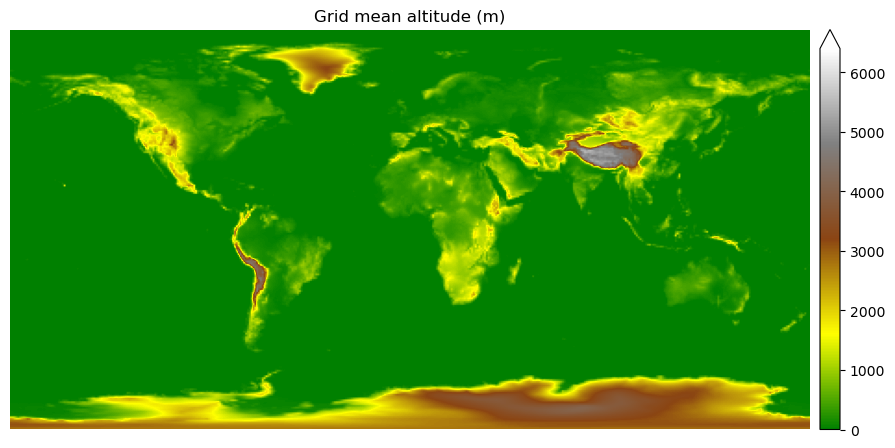

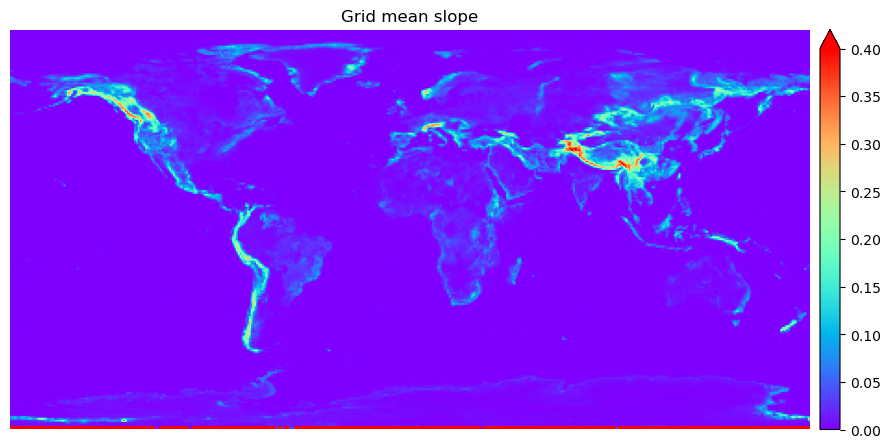

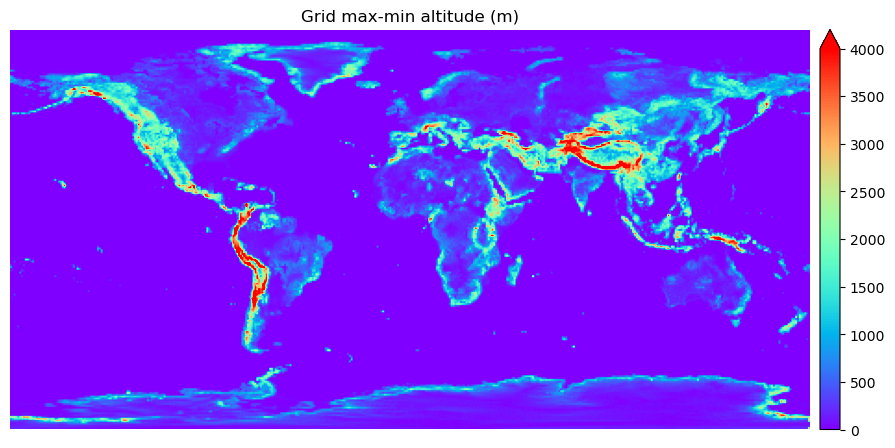

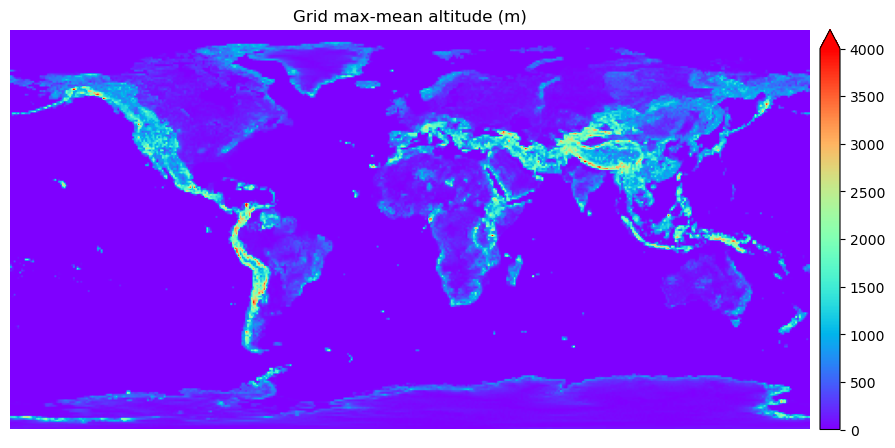

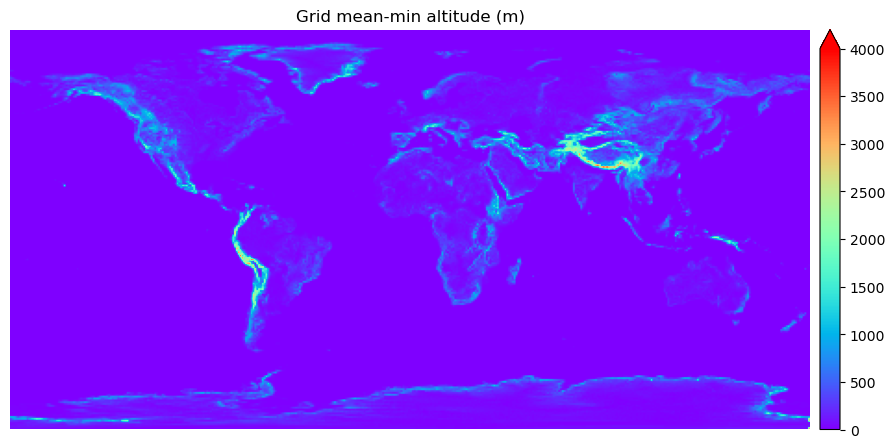

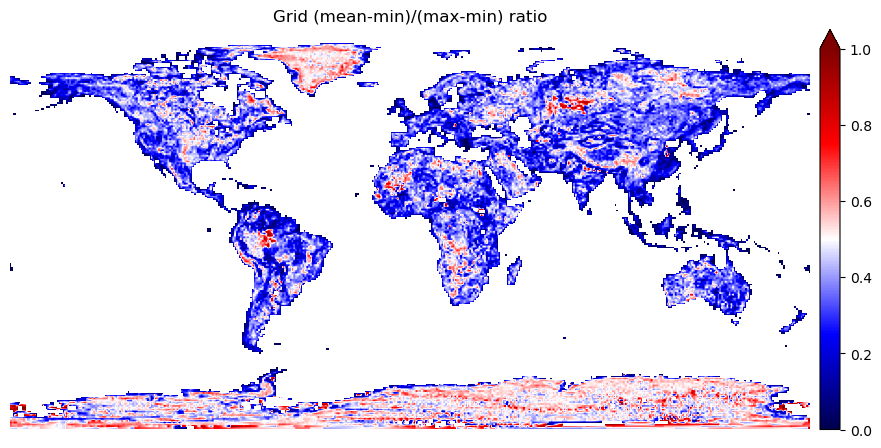

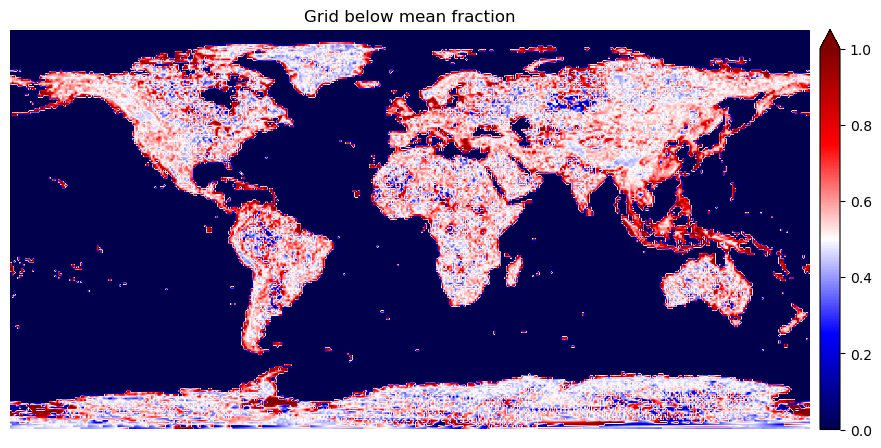

In [5]:
show_map(stats[:,:,0],hcm,0,Hmax,"Grid mean altitude (m)")
show_map(stats[:,:,4],'rainbow',0,0.4,"Grid mean slope")
show_map(stats[:,:,1]-stats[:,:,2],'rainbow',0,4000,"Grid max-min altitude (m)")
show_map(stats[:,:,1]-stats[:,:,0],'rainbow',0,4000,"Grid max-mean altitude (m)")
show_map(stats[:,:,0]-stats[:,:,2],'rainbow',0,4000,"Grid mean-min altitude (m)")
# show_map(-stats[:,:,1]/stats[:,:,2],'rainbow',0,5,"Grid (max-mean)/(mean-min) ratio")
show_map((stats[:,:,0]-stats[:,:,2])/(stats[:,:,1]-stats[:,:,2]),'seismic',0,1,"Grid (mean-min)/(max-min) ratio")
show_map(stats[:,:,3],'seismic',0,1,"Grid below mean fraction")

## In-cell distribution of altitude and slope

In [6]:
def show_H_stats(Hc,dx,extent=None,shading=False):
    fig, ax = plt.subplots(ncols=2,figsize=(10,4))
    Hcmax = np.max(Hc)
    im = ax[0].imshow(Hc, cmap=hcm,vmin=0,vmax=Hcmax, origin='lower',interpolation='none',visible=not(shading))
    if shading:
        ls = LightSource(325, 45)
        rgb = ls.shade(Hc, cmap=hcm,vmin=0,vmax=Hcmax, vert_exag=Hcmax/Hmax/dx, blend_mode='soft')
        ax[0].imshow(rgb, origin='lower',extent=extent,interpolation='bilinear')
    plt.colorbar(im,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend=None)
    ax[0].set_xlabel("Lon")
    ax[0].set_ylabel("Lat")
    z_bins = np.linspace(0.,1.0001,257)*Hmax
    
    ax[1].hist(Hc.flatten(),bins=z_bins[1:],density=False, orientation="horizontal",alpha=0.5,label="Distribution")
    ax[1].set_ylim([0,Hcmax])
#     ax[1].set_yticks([])
    ax[1].set_xlabel("Number of pixel")
    ax[1].set_ylabel("Altitude")
    
    ax_cum = ax[1].twiny()
    ax_cum.hist(Hc.flatten(),bins=z_bins[:], density=True, histtype="step",color='orange', orientation="horizontal",
                cumulative=True, label="CDF")
    ax_cum.set_xlim([0,1])
    Hc_mean = np.mean(Hc)
    above_mean_ratio = np.mean(Hc>Hc_mean)
    ax[1].axhline(np.mean(Hc),color='r',linestyle='--',label='Mean')
    ax_cum.text(1/2,Hcmax*3/4,str(round(above_mean_ratio*100))+' % > mean',color='r',ha='center', va='center')
    ax_cum.set_xlabel("CDF")
    lines, labels = ax[1].get_legend_handles_labels() ; lines2, labels2 = ax_cum.get_legend_handles_labels()
    ax[1].legend(lines + lines2, labels + labels2, loc=0)
    plt.show()
    

def show_S_stats(Hc,dx,extent=None,lat=0.,Smax = 1.2,nsbins=61,deg=False):
    fig, ax = plt.subplots(ncols=2,figsize=(10,4))
    Hcmax = np.max(Hc)
    Hc_slopes = np.sqrt( ((Hc[:-1,:-1]+Hc[1:,:-1]-Hc[:-1,1:]-Hc[1:,1:])/2/dx/np.cos(np.pi*(lat)/180))**2 + ((Hc[:-1,:-1]+Hc[:-1,1:]-Hc[1:,:-1]-Hc[1:,1:])/2/dx)**2 )
    
    if deg:
        Smax = 90
        slope_bins = np.linspace(0.,90,91)
        Hc_slopes = 180/np.pi*np.arctan(Hc_slopes)
    else:
        slope_bins = np.linspace(0.,Smax,nsbins)
    z_bins = np.linspace(0.,1.0001,257)*Hmax
    
    ims = ax[0].imshow(Hc_slopes, cmap='rainbow',vmin=0,vmax=Smax,extent=extent, origin='lower',interpolation='none')
    plt.colorbar(ims,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend='max')
    ax[0].set_xlabel("Lon")
    ax[0].set_ylabel("Lat")
    
    hist_field,_,_,imhs = ax[1].hist2d(Hc_slopes.flatten(),((Hc[:-1,:-1]+Hc[1:,:-1]+Hc[:-1,1:]+Hc[1:,1:])/4).flatten(),
                                       bins=(slope_bins,z_bins),density=False,cmap='magma_r',
                                       norm=matplotlib.colors.LogNorm(vmin=1,vmax=Hc_slopes.size/10) )
    plt.colorbar(imhs,ax=ax[1],fraction=0.1, pad=0.01,orientation='vertical',extend='max')
    ax[1].set_ylim([0,Hcmax])
    ax[1].set_xlim([0,Smax])
    ax[1].set_xlabel("Slope")
    if not(deg):
        ax[1].plot( np.sum(hist_field * (slope_bins[1:]/2+slope_bins[:-1]/2).reshape((len(slope_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0) ,(z_bins[1:]+z_bins[:-1])/2  , color='chartreuse',lw=1.5)
    plt.show()

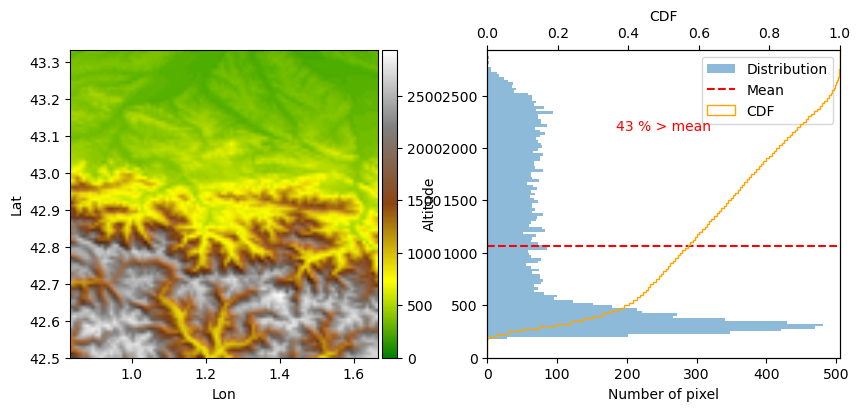

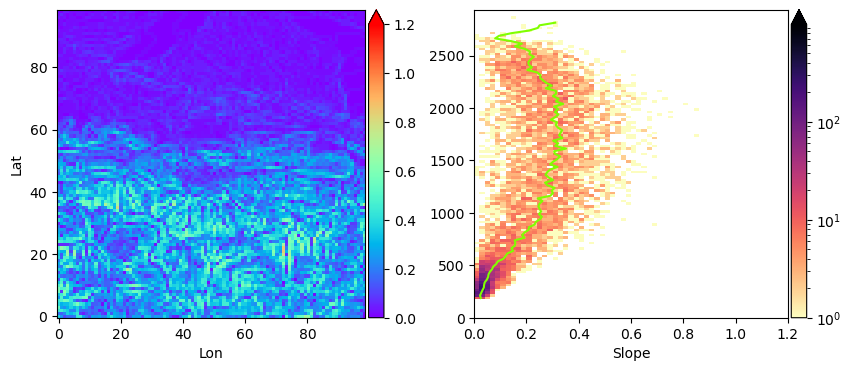

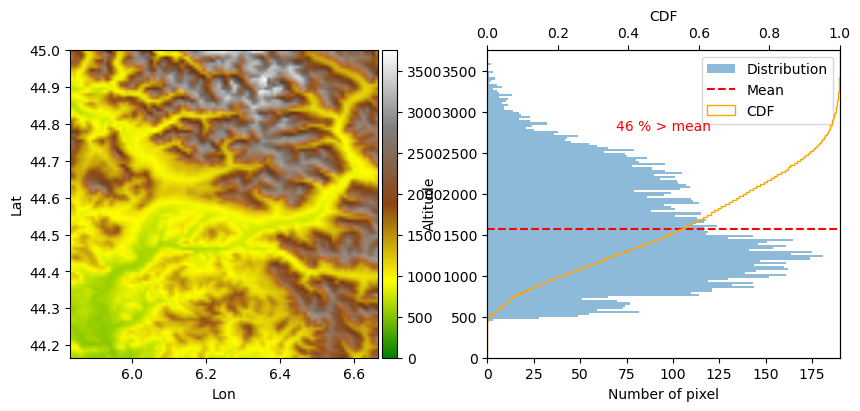

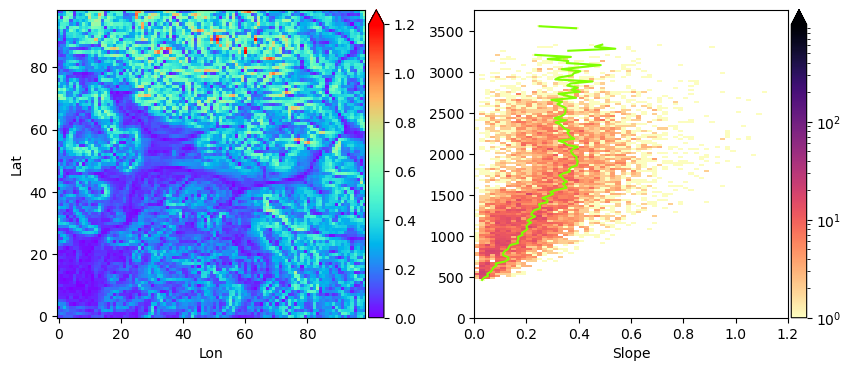

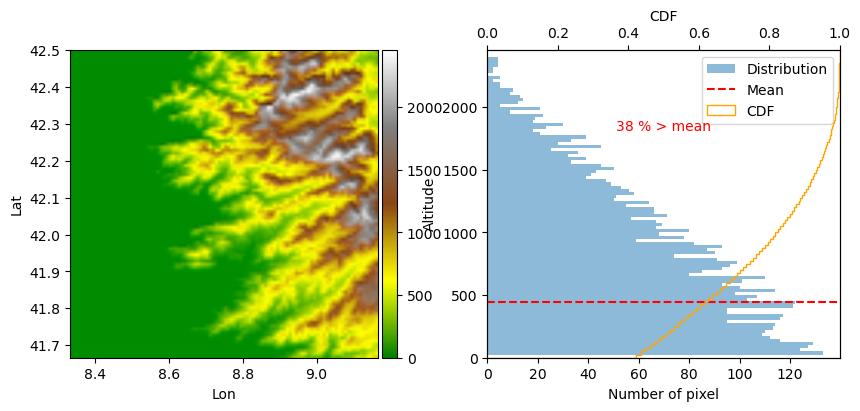

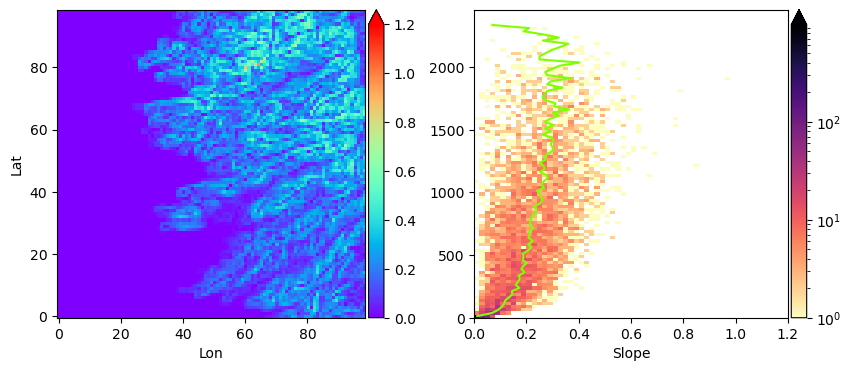

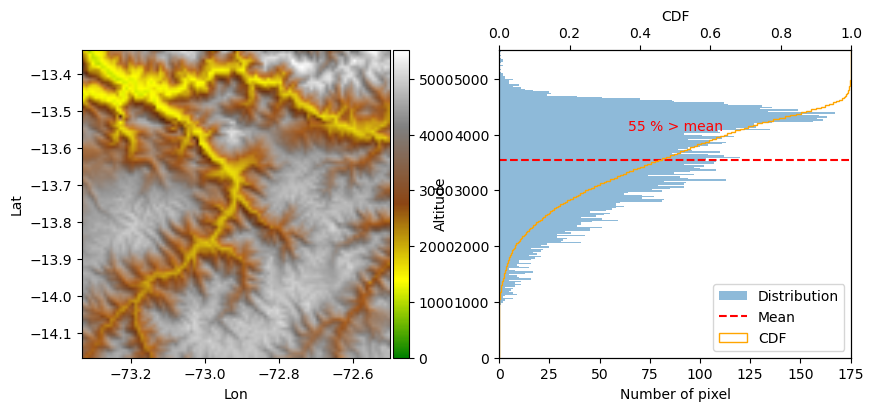

In [7]:
def show_cell_stats(i,j):
    Hc = H[j*c:(j+1)*c,i*c:(i+1)*c] /255 * Hmax
    extent=(-180+i*c*res,-180+(i+1)*c*res,-90+j*c*res,-90+(j+1)*c*res)
    show_H_stats(Hc,dx,extent=extent,shading=True)
    show_S_stats(Hc,dx,extent=None,lat=-90+j*c*res)
    
show_cell_stats(216+1,216-55) # Pyrrénées arriégeoises 
show_cell_stats(216+1,216-57) # Pyrrénées arriégeoises
show_cell_stats(216+7,216-55) # Alpes Gap
show_cell_stats(216+10,216-58) # Corse
show_cell_stats(128,91) # Pérou

## Comparison with high-resolution topography of Chartreuse mountains
High-resolution topography taken from : https://geoservices.ign.fr/rgealti

The altitude distibution is similar. But the slopes are underestimated in the 1km resolution dataset. Especially here because Chartreuse has a lot of cliffs.

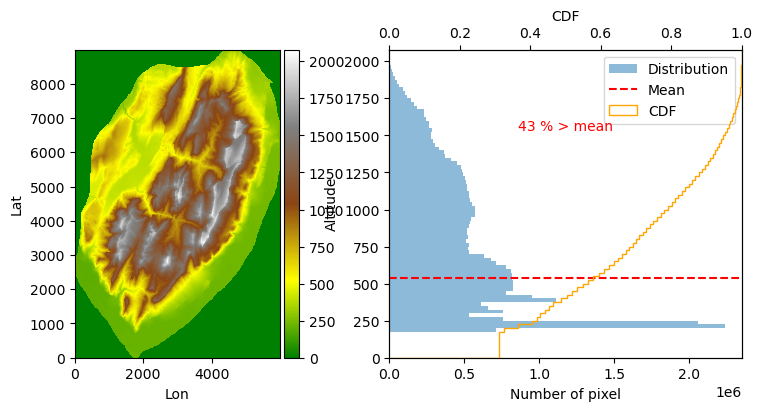

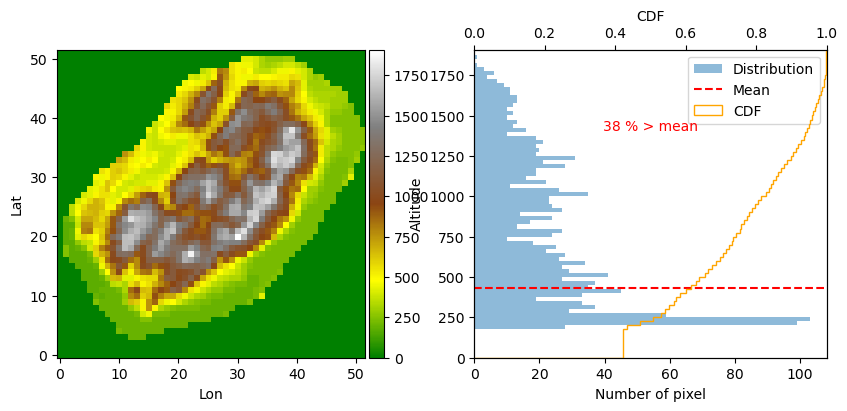

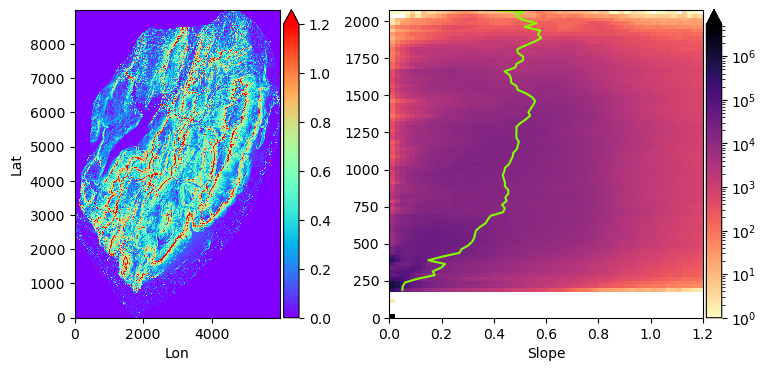

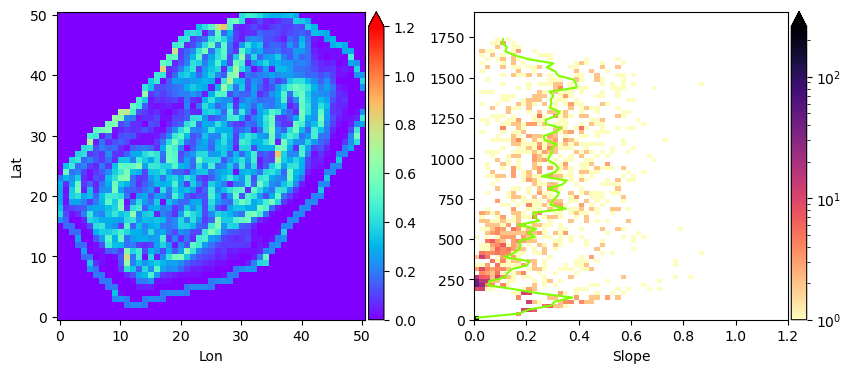

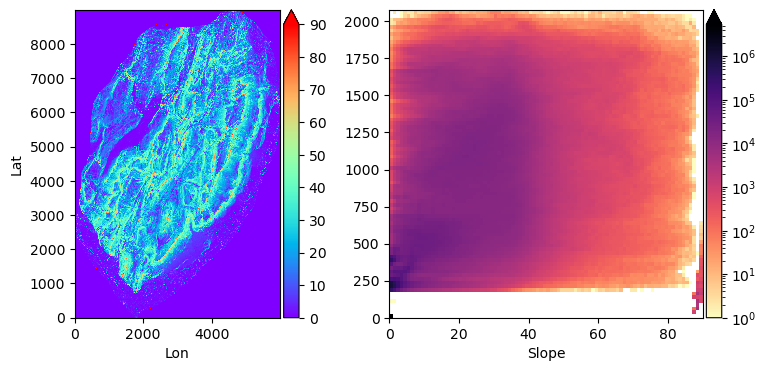

In [8]:
Hchartreuse_hd = np.array(xr.open_dataset(path+"Topo_Chartreuse.nc").Band1)
Hchartreuse_hd[ np.transpose(np.sum(mpimg.imread(path+"Chartreuse_domain.png")[:,:,:3] , axis=2) == 3.) ] = 0.

Hchartreuse_gebco = Hmax/255*np.flipud(np.asarray(Image.open(path+"Chartreuse_Gebco.png"))[:,:,0])

show_H_stats(Hchartreuse_hd,5)
show_H_stats(Hchartreuse_gebco,dx)

show_S_stats(Hchartreuse_hd,5)
show_S_stats(Hchartreuse_gebco,dx,lat=45.4)
show_S_stats(Hchartreuse_hd,5,deg=True)